<a href="https://colab.research.google.com/github/krishnakanth-pawar/AQI_Predictor/blob/main/AQI_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv("city_day.csv")
data.head(-10)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29516,Visakhapatnam,2020-06-17,17.05,73.22,6.08,36.31,24.23,6.69,0.54,11.08,26.09,2.96,6.96,1.39,90.0,Satisfactory
29517,Visakhapatnam,2020-06-18,21.16,88.80,4.94,42.96,26.79,3.22,0.68,11.05,27.65,4.38,7.65,1.69,71.0,Satisfactory
29518,Visakhapatnam,2020-06-19,14.41,66.81,6.22,40.06,26.10,7.51,1.07,13.23,27.34,2.55,8.98,1.45,110.0,Moderate
29519,Visakhapatnam,2020-06-20,26.67,86.29,3.78,37.36,22.46,15.05,0.74,11.76,41.97,3.14,11.89,1.87,74.0,Satisfactory


In [2]:
# Checking for missing values
data.isnull().sum()

,0
City,0
Date,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
NH3,10328
CO,2059
SO2,3854


In [3]:
data.dropna(axis=0, inplace=True)

In [4]:
!pip install -U plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [5]:

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Ensure Date is proper datetime
data['Date'] = pd.to_datetime(data['Date'])

# 1) AQI Trend Over Time
fig1 = px.line(
    data,
    x='Date',
    y='AQI',
    color='City',
    title='AQI Trend Over Time'
)
fig1.show()

# 2) AQI Distribution by City
fig2 = px.box(
    data,
    x='City',
    y='AQI',
    title='AQI Distribution by City'
)
fig2.update_layout(xaxis={'categoryorder': 'total descending'})
fig2.show()

# 3) Scatter Plot Matrix (robust approach)
selected_features = ['PM2.5', 'NO2', 'CO', 'O3', 'AQI']

try:
    # Preferred (works with plotly >= 5.14)
    fig3 = px.scatter_matrix(data[selected_features], title='Scatter Plot Matrix')
    fig3.show()
except AttributeError:
    # Fallback for older plotly + pandas 2.x
    dims = [{'label': col, 'values': data[col]} for col in selected_features]
    fig3 = go.Figure(data=go.Splom(
        dimensions=dims,
        diagonal_visible=False,
        showupperhalf=False,
        marker=dict(size=5, opacity=0.7)
    ))
    fig3.update_layout(title='Scatter Plot Matrix', dragmode='select')
    fig3.show()


In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

feature_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
# Splitting the dataset into features (X) and target (y)
X = data[feature_columns]
y = data['AQI']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Defining and compiling the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model

history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1  # Ensure this is set
)

#history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 27858.5117 - val_loss: 17959.5723
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12384.8057 - val_loss: 4674.5801
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3945.6274 - val_loss: 2882.4705
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2754.8789 - val_loss: 1821.1509
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1695.8411 - val_loss: 1310.7714
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1207.5096 - val_loss: 1075.0098
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1140.0983 - val_loss: 952.9515
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1055.3051 - val_loss: 877.0960
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 936.7968 - val_loss: 823.7581
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 974.9062 - val_loss: 782.5903
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 928.9630 - val_loss:

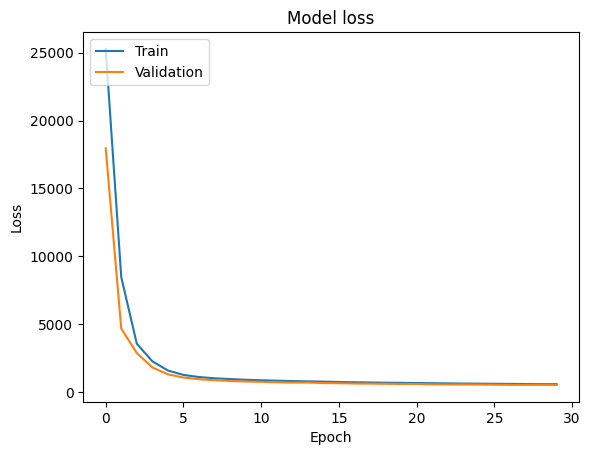

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 596.3603
Mean Squared Error on Test Data: 529.8846435546875


In [8]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test)
print("Mean Squared Error on Test Data:", loss)

In [9]:
#this is the user input he wants to check the AQI
model.save('model.h5')
user_input = pd.DataFrame({
    'PM2.5': [200],
    'PM10': [124],
    'NO': [1.44],
    'NO2': [20],
    'NOx': [12],
    'NH3': [10],
    'CO': [0.1],
    'SO2': [15],
    'O3': [127],
    'Benzene': [0.20],
    'Toluene': [6],
    'Xylene': [0.06]
})

user_input_scaled = scaler.transform(user_input)

user_pred = model.predict(user_input_scaled)

print(f"Predicted AQI: {user_pred[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted AQI: 296.3175048828125
